# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('../Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('../Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

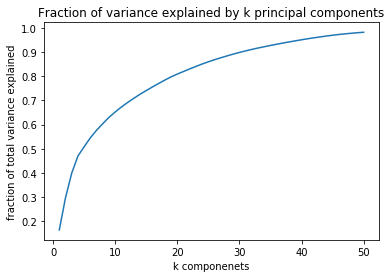

In [6]:
def P1():
### STUDENT START ###

    # run principal component analysis on the data
    pca_50 = PCA(n_components=50)
    pca_50.fit(train_data)
    cum_sum = []
    for i in range(1,51):
        # cumuative sum of explained variance
        cumsum = np.cumsum(pca_50.explained_variance_ratio_[:i])
        cum_sum.append(cumsum) 
    plt.plot(np.arange(1,len(cumsum)+1), cumsum[0:len(cumsum)])
    plt.title('Fraction of variance explained by k principal components')
    plt.xlabel('k componenets')
    plt.ylabel('fraction of total variance explained')
    plt.show()

### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

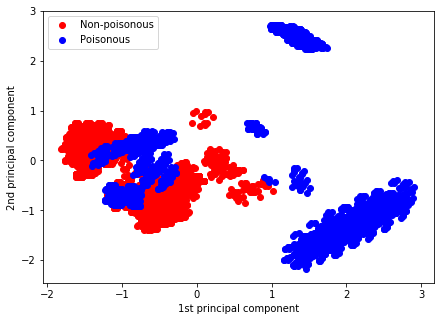

In [7]:
def P2():
### STUDENT START ###

    # use only first two components
    pca_2 = PCA(n_components=2)
    trained_pc = pca_2.fit_transform(train_data)
    plt.figure(figsize=(7,5))
    plt.scatter(trained_pc[:,0][train_labels==0], 
                trained_pc[:,1][train_labels==0], 
                color='r', label='Non-poisonous')
    plt.scatter(trained_pc[:,0][train_labels==1], 
                trained_pc[:,1][train_labels==1], 
                color='b', label='Poisonous')
    plt.xlabel('1st principal component')
    plt.ylabel('2nd principal component')
    plt.legend(loc=2)
    plt.show()
    
### STUDENT END ###
P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

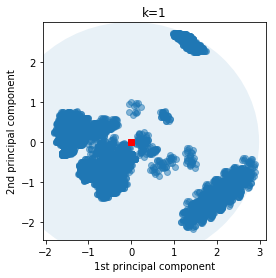

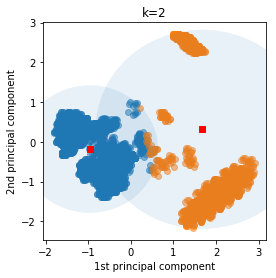

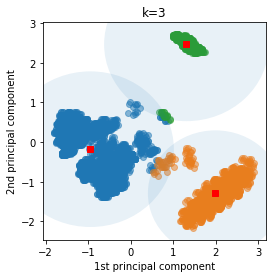

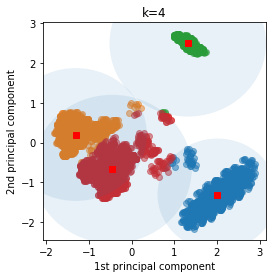

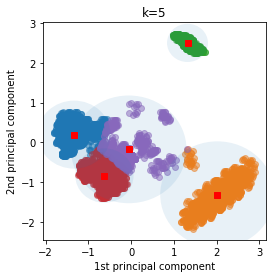

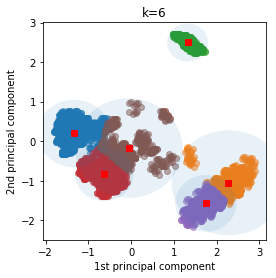

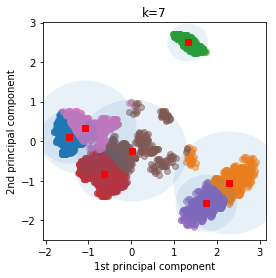

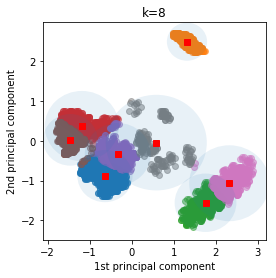

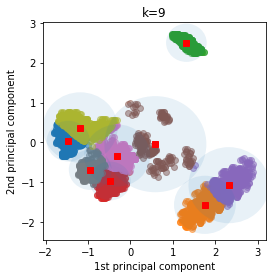

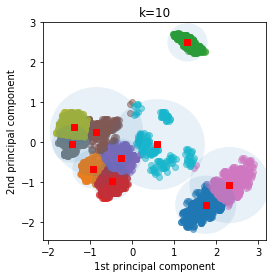

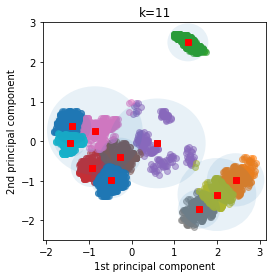

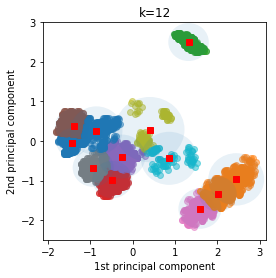

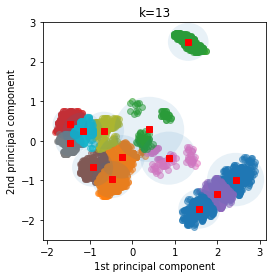

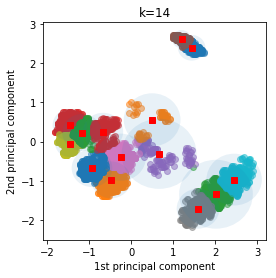

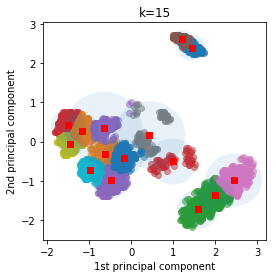

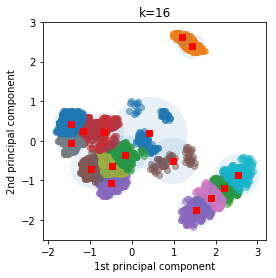

In [13]:
def P3():
### STUDENT START ###

    # same 2d projected data as P2()
    pca_2 = PCA(n_components=2)
    train_pc = pca_2.fit_transform(train_data)
    for n in range(1,17):
        km = KMeans(n_clusters=n, init='k-means++')
        distance = km.fit_transform(train_pc)
        # loop over diff cluster center
        plt.figure(figsize=(4,4))
        for i, c in enumerate(km.cluster_centers_):
            # scatter plot
            plt.scatter(train_pc[:,0][km.labels_==i], 
                        train_pc[:,1][km.labels_==i], 
                        alpha=0.5)
            # cluster center
            plt.plot(c[0], c[1], 'rs')
            # distance of points that correspond to the current cluster
            distance_subset = distance[km.labels_==i]
            # find max distance
            max_distance = np.amax(distance_subset[:,i])
            # plot circle with radius = max distance at the cluster center
            circle = plt.Circle(c, max_distance, alpha=0.1)
            plt.gca().add_artist(circle)
        plt.xlabel('1st principal component')
        plt.ylabel('2nd principal component')
        plt.title('k={}'.format(n))
        plt.show() 
    
### STUDENT END ###
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

/anaconda2/lib/python2.7/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


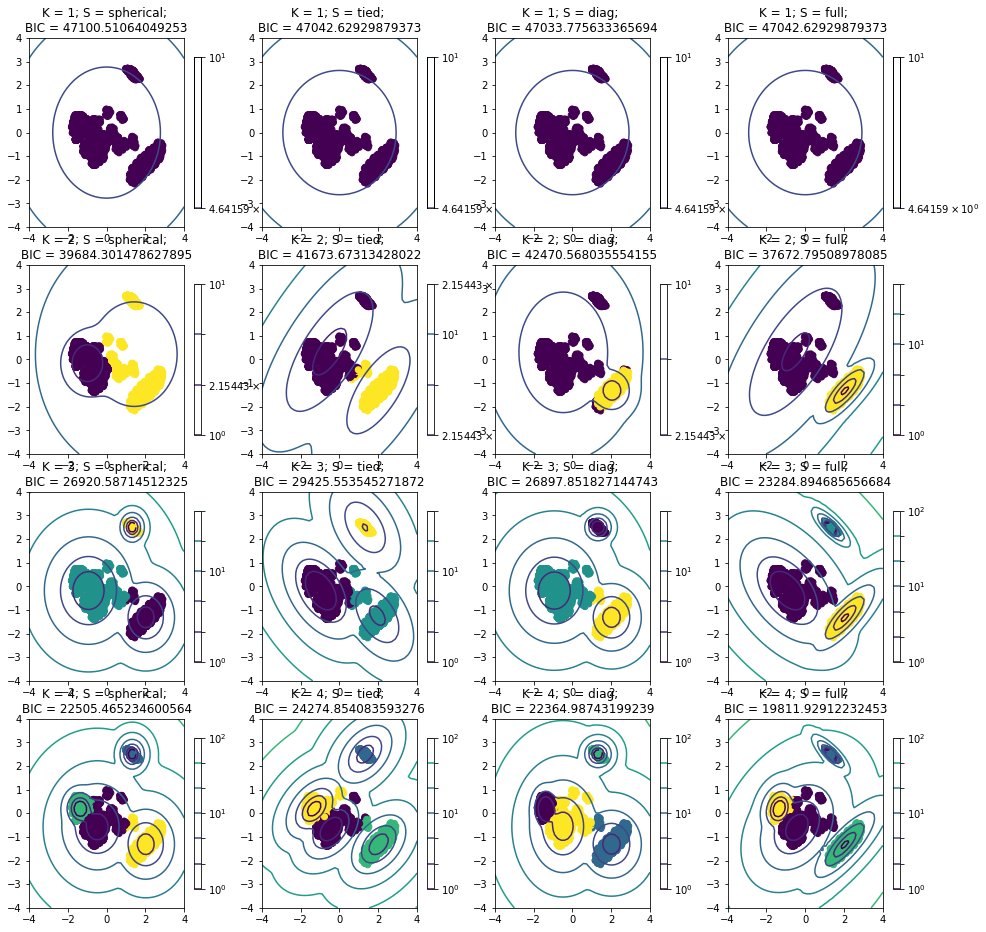

In [14]:
def P4():
### STUDENT START ###

    # same 2d projected data as P2()
    pca_2 = PCA(n_components=2)
    train_pc = pca_2.fit_transform(train_data)
    
    comps = [1, 2, 3, 4]
    structures = ['spherical', 'tied', 'diag', 'full']

    plt.figure(figsize=(16, 16))
    #p = plt.subplot(1, 3, 1)
    i = 0

    for comp in comps:
        for structure in structures:
            i += 1

            gm_mod = GaussianMixture(n_components = comp, covariance_type = structure)
            p = plt.subplot(len(comps), len(structures), i)

            gm_mod.fit(train_pc)
            y_hat = gm_mod.predict(train_pc)

            p.scatter(train_pc[:, 0], train_pc[:, 1], c=y_hat)
            
            # estimated density contous plot code from 
            # http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py
            # display predicted scores by the model as a contour plot
            x = np.linspace(-4., 4.)
            y = np.linspace(-4., 4.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm_mod.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                             levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')

            plt.title("K = " + str(comp) + "; S = " + str(structure) + "; \nBIC = " + str(gm_mod.bic(train_pc)))

### STUDENT END ###
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [19]:
def P5():
### STUDENT START ###

    # same 2d projected data as P2()
    pca_2 = PCA(n_components=2)
    train_pc = pca_2.fit_transform(train_data)
    test_pc = pca_2.transform(test_data)
    # two 4-component full covariance GMMs
    gm_mod_pos = GaussianMixture(n_components = 4, covariance_type = 'full')
    gm_mod_neg = GaussianMixture(n_components = 4, covariance_type = 'full')
    # fit each GMM to each label
    # per P2, positive (poisonous) and negative (non-poisonous) 
    gm_mod_pos.fit(train_pc[train_labels==1])
    gm_mod_neg.fit(train_pc[train_labels==0])
    # compute weighted log probabilites
    log_prob_pos = gm_mod_pos.score_samples(test_pc)
    log_prob_neg = gm_mod_neg.score_samples(test_pc)
    # predict the type of mushroom after comparing probabilities
    pred = np.where(log_prob_pos>=log_prob_neg, 1, 0)
    accuracy = metrics.accuracy_score(test_labels, pred)
    print 'Accuracy: {:.4}%'.format(accuracy*100)

### STUDENT END ###

P5()

Accuracy: 95.02%


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [18]:
def P6():
### STUDENT START ###

    structures = ['spherical', 'tied', 'diag', 'full']
    best_pca_n = 0
    best_gmm_n = 0
    best_accuracy = 0
    print '{0:<25s}{1:<25s}{2:<20s}{3:<10s}'.format('# of PCA components', '# of GMM components', 'Covariance type', 'Accuracy')
    
    for pca_n_components in range(1,25):
        for gmm_n_components in range(1,25):
            for structure in structures:
                # number of covariance matrix from
                # http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html
                # and 
                # http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html
                if structure == 'full':
                    covariances = pca_n_components**2
                elif structure == 'tied':
                    covariances = (pca_n_components * (pca_n_components + 1))/2
                elif structure == 'diag':
                    covariances = pca_n_components
                elif structure == 'spherical':
                    covariances = 1
                # run only if less than 50 parameters
                total_n_params = ((pca_n_components + covariances) * gmm_n_components) * 2
                if total_n_params > 50:
                    continue
                else:
                    # PCA
                    pca = PCA(n_components=pca_n_components)
                    train_pc = pca.fit_transform(train_data)
                    test_pc = pca.transform(test_data)
                    
                    # two GMM
                    gm_mod_pos = GaussianMixture(n_components = gmm_n_components, covariance_type = structure)
                    gm_mod_neg = GaussianMixture(n_components = gmm_n_components, covariance_type = structure)
                    # fit each GMM to each label
                    # per P2, positive (poisonous) and negative (non-poisonous) 
                    gm_mod_pos.fit(train_pc[train_labels==1])
                    gm_mod_neg.fit(train_pc[train_labels==0])
                    # compute weighted log probabilites
                    log_prob_pos = gm_mod_pos.score_samples(test_pc)
                    log_prob_neg = gm_mod_neg.score_samples(test_pc)
                    # predict the type of mushroom after comparing probabilities
                    pred = np.where(log_prob_pos>=log_prob_neg, 1, 0)
                    accuracy = metrics.accuracy_score(test_labels, pred)
                    if accuracy > best_accuracy:
                        best_accuracy = accuracy
                        best_pca_n = pca_n_components
                        best_gmm_n = gmm_n_components
                        best_structure = structure
                    print '{0:<25}{1:<25}{2:<20s}{3:<.4}%'.format(pca_n_components, gmm_n_components, structure, accuracy*100)
    print '--------------------------------------------------------------------------------'
    print 'Model that gives the best accuracy with the fewest parameters:'
    print '{0:<25s}{1:<25s}{2:<20s}{3:<10s}'.format('# of PCA components', '# of GMM components', 'Covariance type', 'Accuracy')
    print '{0:<25}{1:<25}{2:<20s}{3:<.4}%'.format(best_pca_n, best_gmm_n, best_structure, best_accuracy*100)
### STUDENT END ###

P6()

# of PCA components      # of GMM components      Covariance type     Accuracy  
1                        1                        spherical           84.43%
1                        1                        tied                84.43%
1                        1                        diag                84.43%
1                        1                        full                84.43%
1                        2                        spherical           89.86%
1                        2                        tied                88.35%
1                        2                        diag                89.86%
1                        2                        full                89.86%
1                        3                        spherical           90.84%
1                        3                        tied                92.17%
1                        3                        diag                90.93%
1                        3                        full                90

7                        1                        diag                91.01%
7                        2                        spherical           88.08%
7                        3                        spherical           97.33%
8                        1                        spherical           87.46%
8                        1                        diag                91.37%
8                        2                        spherical           88.88%
9                        1                        spherical           87.54%
9                        1                        diag                90.3%
9                        2                        spherical           87.54%
10                       1                        spherical           87.72%
10                       1                        diag                91.19%
10                       2                        spherical           91.28%
11                       1                        spherical           87.72%
